# Analyze performance of LSTM (Model 3) on Shasta Reservoir

In this notebook, we analyze the performance of LSTM Model 3 using data from Shasta reservoir.
Recall that LSTM Model 2 takes in inflow and the day of the year (DOY) as input, and outputs the predicted release. Model 3 also internally models a storage state as an input, i.e. at every timestep the previous storage is updated with the previous outflow and the current inflow. This notebook is organized in serveral sections:

1. Data processing: manipulate data to use with the models
2. Analyze optimal hyperparameters, using results from grid search conducted in 1_model1_tuning.py
3. Plot performance on train, val, test sets. Get R2 measure.
4. Analyze relationship between cell states and observed storage

We also analyze each of the variants of Model 3:
1. Model 3a: standardized and trained with MSE loss
2. Model 3b: normalized and trained with RMSLE loss

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import os

In [2]:
print(f'Old working directory: {os.getcwd()}')
# change directory out of subdirectory 'experiments'
os.chdir('..')
print(f'Current working directory: {os.getcwd()}')

Old working directory: c:\Users\mattc\Documents\DL-reservoir-modeling\experiments
Current working directory: c:\Users\mattc\Documents\DL-reservoir-modeling


## Data Processing

In [3]:
from src.data.data_processing import *
from src.data.data_fetching import *
from torch.utils.data import DataLoader, TensorDataset

# Read in data, columns are [inflow, outflow, storage]
df = usbr_fetch_data(name='Shasta', vars=['inflow', 'outflow', 'storage'])
# Add day of the year (doy) as another column
df['doy'] = df.index.to_series().dt.dayofyear
# Select data window (beginning of 1944 to end of 2022)
df = df['1944-01-01':'2022-12-31'].copy()

### Standardized

In [4]:
# Run data processing pipeline
pipeline_std = processing_pipeline(train_frac=0.6, val_frac=0.2, test_frac=0.2, chunk_size=3*365, pad_value=-1)
# train and val of shape (#chunks, chunksize, [inflow, outflow, storage, doy]), 
# test of shape (timesteps, [inflow, outflow, storage, doy])
ts_train_std, ts_val_std, ts_test_std = pipeline_std.process_data(df) 

# Separate inputs(X) and targets (y)
# select inflow and doy as input features
X_train_std, X_val_std, X_test_std = ts_train_std[:, :, [0, 3]], ts_val_std[:, :, [0, 3]], ts_test_std[:, :, [0, 3]]
# select outflow as target feature
y_train_std, y_val_std, y_test_std = ts_train_std[:, :, [1]], ts_val_std[:, :, [1]], ts_test_std[:, :, [1]]

# Create PyTorch dataset and dataloader
dataset_train_std, dataset_val_std = (TensorDataset(X_train_std, y_train_std), TensorDataset(X_val_std, y_val_std))
# shuffle = False to preserve time order
dataloader_train_std, dataloader_val_std = (DataLoader(dataset_train_std, batch_size=1, shuffle=False), 
                                                     DataLoader(dataset_val_std, batch_size=1, shuffle=False))

### Normalized

In [5]:
# Run data processing pipeline
pipeline_nm = processing_pipeline(train_frac=0.6, val_frac=0.2, test_frac=0.2, chunk_size=3*365, pad_value=-1, transform_type='normalize', fill_na_method='mean')
# Train and val of shape (#chunks, chunksize, [inflow, outflow, storage, doy]), test of shape (timesteps, [inflow, outflow, storage, doy])
ts_train_nm, ts_val_nm, ts_test_nm = pipeline_nm.process_data(df) 

# Separate inputs(X) and targets (y)
# select inflow and doy as input features
X_train_nm, X_val_nm, X_test_nm = ts_train_nm[:, :, [0, 3]], ts_val_nm[:, :, [0, 3]], ts_test_nm[:, :, [0, 3]]
# select outflow as target feature
y_train_nm, y_val_nm, y_test_nm = ts_train_nm[:, :, [1]], ts_val_nm[:, :, [1]], ts_test_nm[:, :, [1]]

# Create PyTorch dataset and dataloader
dataset_train_nm, dataset_val_nm = (TensorDataset(X_train_nm, y_train_nm), TensorDataset(X_val_nm, y_val_nm))
# shuffle = False to preserve time order
dataloader_train_nm, dataloader_val_nm = (DataLoader(dataset_train_nm, batch_size=1, shuffle=False), 
                                                     DataLoader(dataset_val_nm, batch_size=1, shuffle=False))

In [6]:
# check lengths of train/val/test sets
original_train_len = int(round(df['1944-01-01':'2022-12-31'].shape[0] * pipeline_std.train_frac))
original_val_len = int(round(df['1944-01-01':'2022-12-31'].shape[0] * pipeline_std.val_frac))
original_test_len = df['1944-01-01':'2022-12-31'].shape[0] - (original_train_len + original_val_len)

## Analyze Model 3a

### Optimal Hyperparameters for Model 3a

We conducted a small grid search around the optimal parameters of Model 1 (since the two models are similar). The search space is as follows: \
Number LSTM layers; 1\
Hidden size (LSTM): 25, 30, 35\
Hidden size (FF): 10, 15, 20\
Dropout probability: 0.3

On 5 random seeds: 0, 10, 100, 1000, 10000 which we want to average performance over.

In [7]:
# load in results from grid search
grid_df_3a = pd.read_csv('report/results/hyperparameter_tuning/model3a_tuning.csv', index_col=0)

# average performance over the random seeds
num_random_seeds = 5
grid_df_3a['param_id'] = np.repeat(np.arange(int(len(grid_df_3a) / num_random_seeds)), num_random_seeds)
grid_df_mean_3a = grid_df_3a.groupby('param_id').mean()
grid_df_mean_3a.drop(columns=['random_seed'], inplace=True)

# save sorted df
grid_df_mean_3a.sort_values(by=['val_error'], axis=0, inplace=True)
grid_df_mean_3a.to_csv('report/results/hyperparameter_tuning/model3a_avg_tuning.csv')
grid_df_mean_3a[:10]

,num_layers,hidden1,hidden2,dropout,epochs_trained,val_error
param_id,,,,,,
13,1.0,35.0,15.0,0.3,44.8,0.411942
7,1.0,30.0,15.0,0.3,46.4,0.412424
16,2.0,35.0,15.0,0.3,29.6,0.417018
2,1.0,25.0,20.0,0.3,42.6,0.418027
4,2.0,25.0,15.0,0.3,33.8,0.420003
6,1.0,30.0,10.0,0.3,46.2,0.421739
17,2.0,35.0,20.0,0.3,28.0,0.422696
1,1.0,25.0,15.0,0.3,49.2,0.425824
10,2.0,30.0,15.0,0.3,34.2,0.429046


### Load model with optimal hyperparaeters

The optimal hyperparameters are:
Number  of LSTM layers: 1\
LSTM hidden units: 35\
FF hidden units: 15\
dropout: 0.3

In [8]:
from src.models.model_zoo import *
from src.models.predict_model import *
from src.models.train_model import *
from src.models.predict_model import *
from sklearn.metrics import r2_score

In [9]:
# instantiate model
input_size = 2
hidden_size1 = 35
hidden_size2 = 15
num_layers = 1
output_size = 1
dropout_prob = 0.3

torch.manual_seed(0)
model3a = LSTMModel3(input_size=input_size, hidden_size1=hidden_size1, 
                             hidden_size2=hidden_size2, output_size=output_size, num_layers=num_layers, dropout_prob=dropout_prob, initial_output=0, initial_implied_storage=0)

# load saved model parameters
model3a.load_state_dict(torch.load('src/models/saved_models/model3a.pt'))

<All keys matched successfully>

In [10]:
model3a.eval()

LSTMModel3(
  (lstm_cell1): LSTMCell(3, 35)
  (lstm_cell2): LSTMCell(35, 35)
  (dropout1): Dropout(p=0.3, inplace=False)
  (linear1): Linear(in_features=35, out_features=15, bias=True)
  (relu1): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (linear2): Linear(in_features=15, out_features=1, bias=True)
)

### Evaluate Model 3a goodness-of-fit

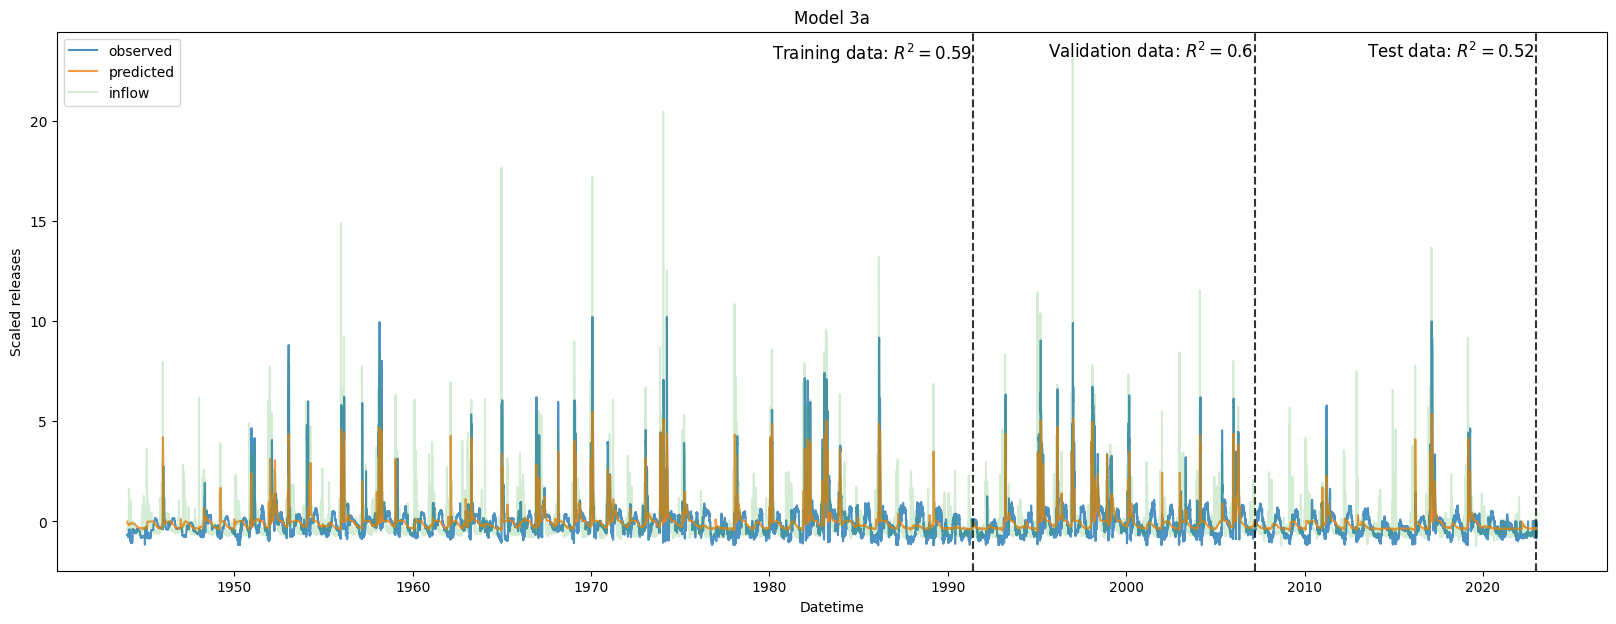

In [11]:
fig, ax = plt.subplots(figsize=(20, 7))
r2_train_3a, r2_val_3a, r2_test_3a = plot_and_eval(model3a, X_train_std, X_val_std, X_test_std, y_train_std, y_val_std, y_test_std, datetime_index=df.index, ax=ax, text_ypos=24, alpha=0.8)
ax.plot((df.inflow-df.inflow.mean()) / df.inflow.std(), label='inflow', alpha=0.2)
ax.legend()
ax.set_title('Model 3a')
# plt.savefig('report/progress_report_1_23_24/figures/model3a.png',dpi=300)
plt.show()

### Analyze Model 3a implied storage states

In [12]:
from src.models.analyze_lstm_cell import *

In [13]:
# Get cell states, shape is (# chunks, timesteps, hidden size)
with torch.no_grad():
    im_storage_train_3a = model3a(X_train_std)[1].detach()
    im_storage_val_3a = model3a(X_val_std)[1].detach()
    im_storage_test_3a = model3a(X_test_std)[1].detach()

In [14]:
# Get observed storage states, shape is (timesteps, )
storage_train = df.storage[:original_train_len].values
storage_val = df.storage[original_train_len:(original_train_len+original_val_len)].values
storage_test = df.storage[(original_train_len+original_val_len):].values

In [15]:
correlation_data = {'training':cell_correlations(cell_states=im_storage_train_3a, storage_states=storage_train),
                    'validation': cell_correlations(cell_states=im_storage_val_3a, storage_states=storage_val),
                    'testing': cell_correlations(cell_states=im_storage_test_3a, storage_states=storage_test)}
df_corr = pd.DataFrame(correlation_data)
df_corr

,training,validation,testing
0,0.791148,0.847439,0.874781


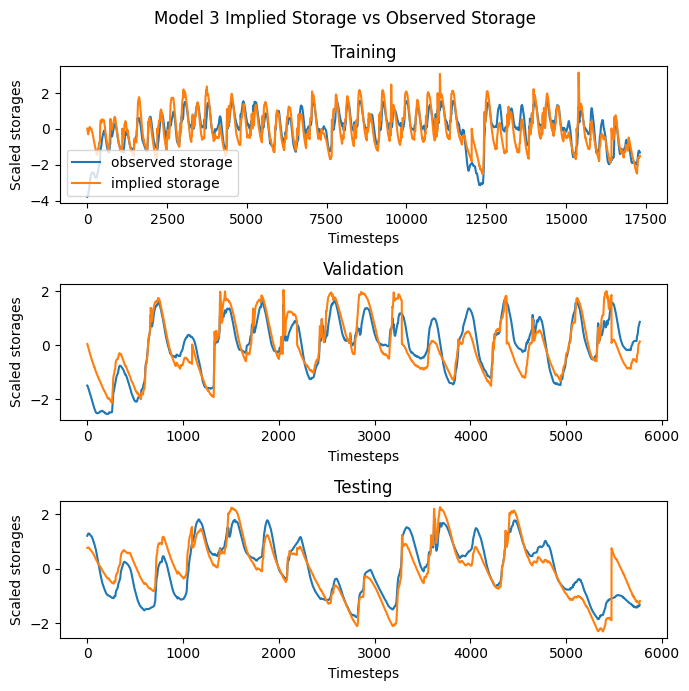

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 7))
plot_storage_cell(cell_states_all=im_storage_train_3a, storage_states=storage_train, cell_id=0, ax=axes[0])
axes[0].legend(['observed storage', 'implied storage'], loc='lower left')
axes[0].set_title('Training')
axes[0].set_xlabel('Timesteps')
axes[0].set_ylabel('Scaled storages')

plot_storage_cell(cell_states_all=im_storage_val_3a, storage_states=storage_val, cell_id=0, ax=axes[1])
axes[1].set_title('Validation')
axes[1].set_xlabel('Timesteps')
axes[1].set_ylabel('Scaled storages')

plot_storage_cell(cell_states_all=im_storage_test_3a, storage_states=storage_test, cell_id=0, ax=axes[2])
axes[2].set_title('Testing')
axes[2].set_xlabel('Timesteps')
axes[2].set_ylabel('Scaled storages')

fig.suptitle('Model 3 Implied Storage vs Observed Storage')
plt.tight_layout()
plt.savefig('report/drafting/2_27_2024/figures/Figure3_model3a_implied_storage.png', dpi=300)
plt.show()

## Analyze Model 3b

### Optimal hyperparameters for Model 3b

In [17]:
# load in results from grid search
grid_df_3b = pd.read_csv('report/results/hyperparameter_tuning/model3b_tuning.csv', index_col=0)

# average performance over the random seeds
num_random_seeds = 5
grid_df_3b['param_id'] = np.repeat(np.arange(int(len(grid_df_3b) / num_random_seeds)), num_random_seeds)
grid_df_mean_3b = grid_df_3b.groupby('param_id').mean()
grid_df_mean_3b.drop(columns=['random_seed'], inplace=True)

# save sorted df
grid_df_mean_3b.sort_values(by=['val_error'], axis=0, inplace=True)
grid_df_mean_3b.to_csv('report/results/hyperparameter_tuning/model3b_avg_tuning.csv')
grid_df_mean_3b[:10]

,num_layers,hidden1,hidden2,dropout,epochs_trained,val_error
param_id,,,,,,
17,2.0,35.0,20.0,0.3,34.4,0.068240
7,1.0,30.0,15.0,0.3,53.6,0.068823
4,2.0,25.0,15.0,0.3,27.2,0.068923
9,2.0,30.0,10.0,0.3,38.8,0.068932
16,2.0,35.0,15.0,0.3,35.4,0.069115
6,1.0,30.0,10.0,0.3,45.2,0.069326
5,2.0,25.0,20.0,0.3,20.6,0.069472
8,1.0,30.0,20.0,0.3,58.8,0.070515
13,1.0,35.0,15.0,0.3,51.4,0.070585


In [18]:
# instantiate model
input_size = 2
hidden_size1 = 35
hidden_size2 = 20
num_layers = 2
output_size = 1
dropout_prob = 0.3

torch.manual_seed(0)
model3b = LSTMModel3(input_size=input_size, hidden_size1=hidden_size1, 
                             hidden_size2=hidden_size2, output_size=output_size, num_layers=num_layers, dropout_prob=dropout_prob, initial_output=0, initial_implied_storage=0)

# load saved model parameters
model3b.load_state_dict(torch.load('src/models/saved_models/model3b.pt'))

<All keys matched successfully>

In [19]:
model3b.eval()

LSTMModel3(
  (lstm_cell1): LSTMCell(3, 35)
  (lstm_cell2): LSTMCell(35, 35)
  (dropout1): Dropout(p=0.3, inplace=False)
  (linear1): Linear(in_features=35, out_features=20, bias=True)
  (relu1): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (linear2): Linear(in_features=20, out_features=1, bias=True)
)

### Evaluate Model 3b goodness-of-fit

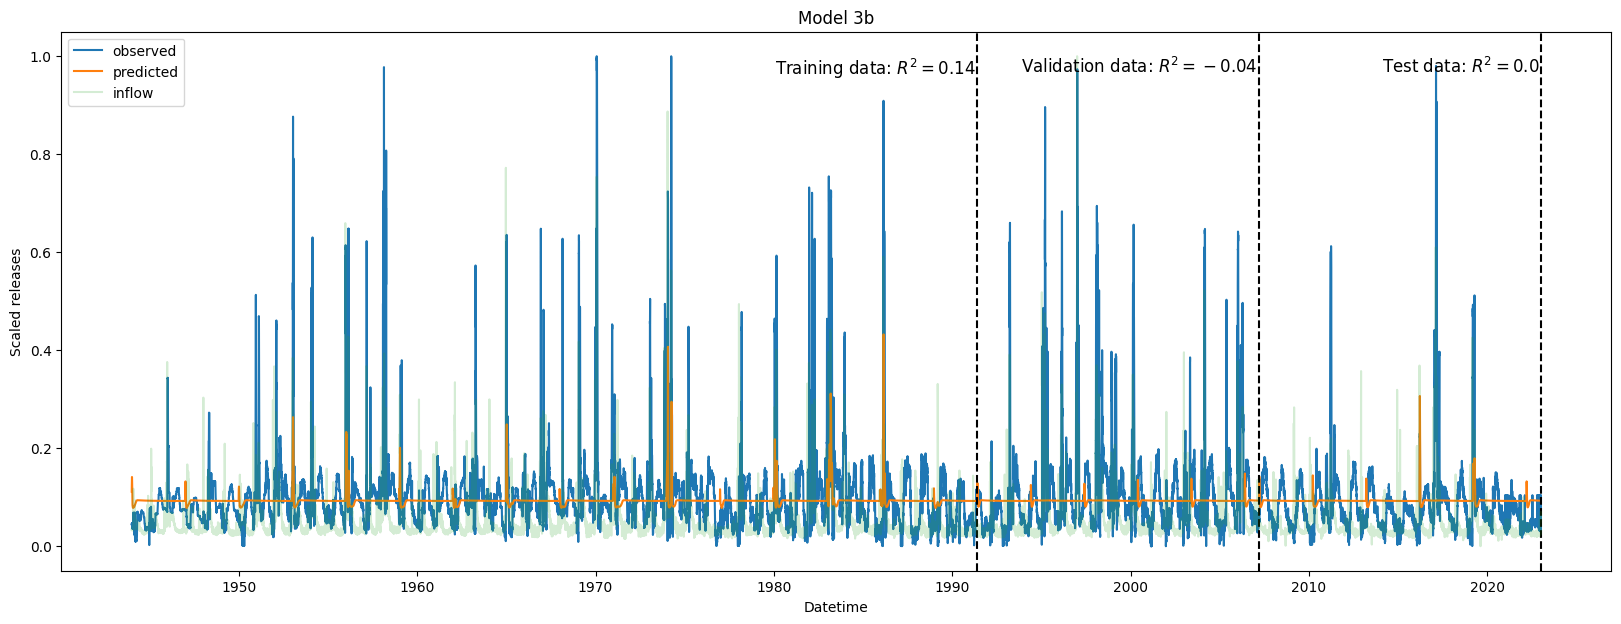

In [21]:
fig, ax = plt.subplots(figsize=(20, 7))
r2_train_3b, r2_val_3b, r2_test_3b = plot_and_eval(model3b, X_train_nm, X_val_nm, X_test_nm, y_train_nm, y_val_nm, y_test_nm, datetime_index=df.index, ax=ax, text_ypos=1, alpha=1)
ax.plot((df.inflow-df.inflow.min()) / (df.inflow.max() - df.inflow.min()), label='inflow', alpha=0.2)
ax.legend()
ax.set_title('Model 3b')
# plt.savefig('report/progress_report_1_23_24/figures/model3b.png', dpi=300)
plt.show()

Model 3b performs extremely poorly.